311552004 李明倫
### 1. Introduction
In lab1, you need to implement a simple neural network from scratch using only Numpy and python standard libraires, any other frameworks (ex: Tensorflow, PyTorch) are not allowed.

#### Requirements
1. Implement simple neural networks with two hidden layers
2. Each hidden layer needs to contain at least one transformation (CNN, Linear, ...) and one activate function (Sigmoid, tanh, ...)
3. Must use backpropagation in this neural network and can only use Numpy and other python standard libraries to implement.
4. Plot the comparison figure that shows the predicted results and the ground-truth.
5. Print the training loss and testing result.

#### Dataset
這次作業題提供兩種資料集，實作出的 neural network 要能夠正確的把資料作分類 
- generate_linear: 
- generate_XOR_easy:

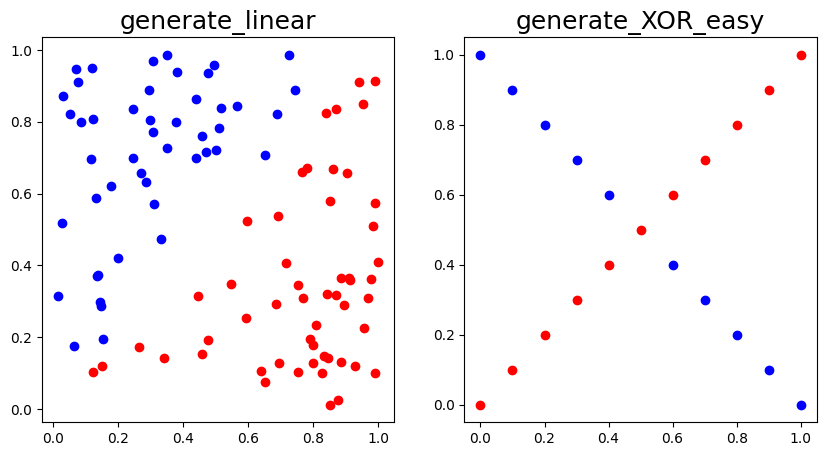

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []

    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)

        if 0.1*i == 0.5:
            continue

        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21, 1)

def show_data(x, y, xx, yy):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('generate_linear', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    
    plt.subplot(1, 2, 2)
    plt.title('generate_XOR_easy', fontsize=18)
    for i in range(xx.shape[0]):
        if yy[i] == 0:
            plt.plot(xx[i][0], xx[i][1], 'ro')
        else:
            plt.plot(xx[i][0], xx[i][1], 'bo')
    plt.show()

x, y = generate_linear()
xx, yy = generate_XOR_easy()
show_data(x, y, xx, yy)

### 2. Experiment setups
#### Sigmoid functions
按照 TA spec 中提及的 hint

In [ ]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

#### Neural Network
在 neural network 的實作上，我定義了兩個 class: Dense, SimpleNet

**Dense**
- 單一層的神經網路，主要內容包括 weight, bias, gradient, activation function, z (線性組合完的結果), a (過完 activation function 的結果)
- 另外定義了一個 update() function，對 weight 跟 bias 做 gradient update

In [26]:
from utils import sigmoid, relu, tanh, identity

class Dense():
    def __init__(self, in_dim, out_dim, activation="sigmoid"):
        self.layer = self.linear(in_dim, out_dim)
        self.grad = [np.zeros(self.layer[0].shape), np.zeros(self.layer[1].shape)]
        self.m = [np.zeros(self.layer[0].shape), np.zeros(self.layer[1].shape)]         # for momentum
        self.v = [np.zeros(self.layer[0].shape), np.zeros(self.layer[1].shape)]         # for RMSprop
        self.t = 0

        if activation == "sigmoid":
            self.activation = sigmoid
        elif activation == "relu":
            self.activation = relu
        elif activation == "tanh":
            self.activation = tanh
        else:
            self.activation = identity

        self.Z = np.zeros((out_dim, 1))
        self.A = np.zeros((out_dim, 1))
        self.dc_dz = np.zeros((out_dim, 1))

    def linear(self, input_dim, output_dim):
        w = np.random.normal(0, 1, (output_dim, input_dim))
        b = np.random.normal(0, 1, (output_dim, 1))
        return [w, b]

    def update(self, new_grad):
        self.layer[0] -= new_grad[0]
        self.layer[1] -= new_grad[1]

**SimpleNet**
- 整個 neural network 的 class，一開始會先用給定的 input_size, hidden_size 與 output_size，去建立整個神經網路，每一層 layer 則透過上面的 Dense 去建立
- 為了彈性起見，我的 network 可以有超過兩層的 hidden layer (透過給定 dimsension 去指定)，但在作業當中還是維持兩層 hidden layer 的設定

#### Backpropagation
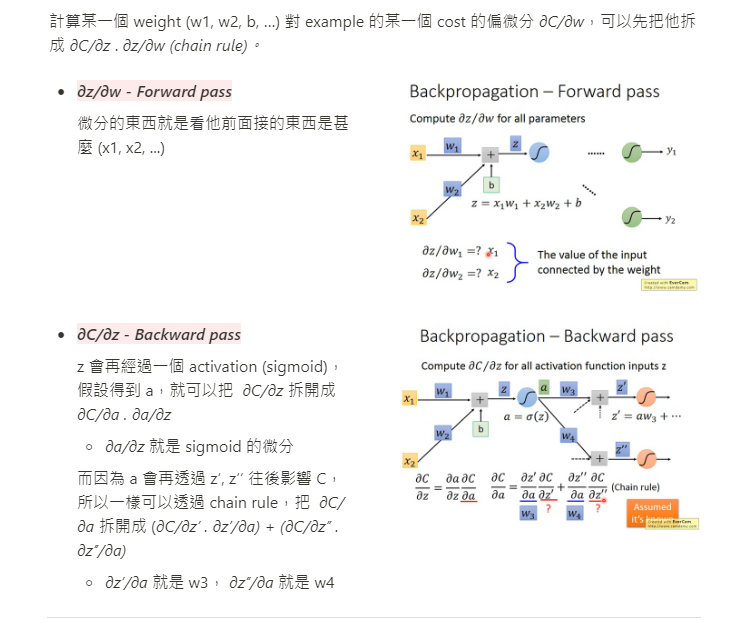
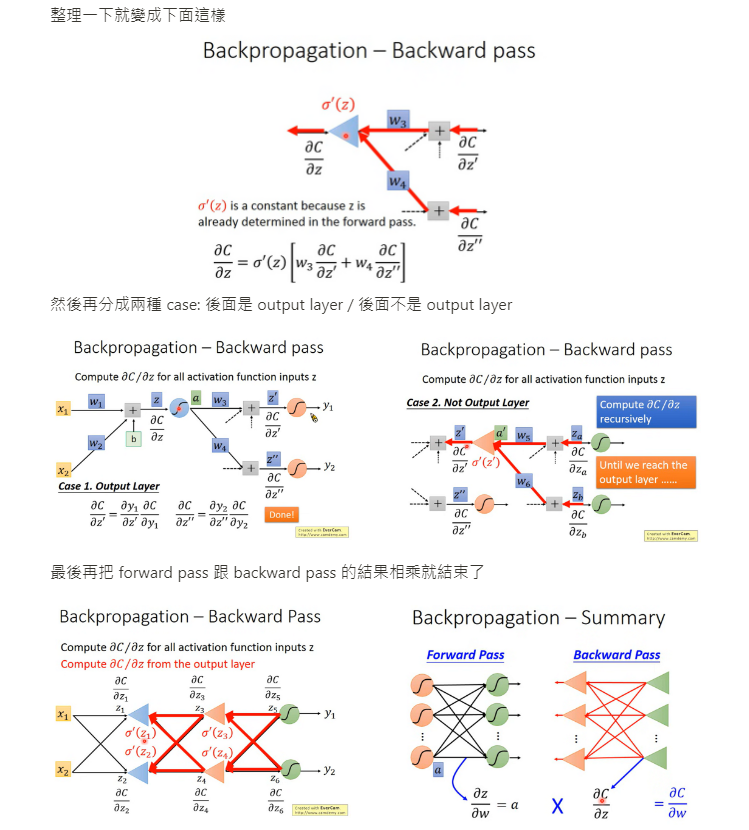

實作了 forward_pass, backward_pass 與 step
- forward_pass: 把 input data 完整的從第一層 layer，透過一連串的線性組合與 activation，一路運算到 output layer
- backward_pass: 把每一層的 dC/dz 從最後一層一路往回算到第一層，然後結合 forward_pass 的結果，計算出中間所有參數 (weight, bias) 的 gradient
- step: 得到所有參數的 gradient 之後，就可以透過不同的 optimizer 去做 gradient descent 的 optimization，這邊我實作了: sgd, momentum, adam

In [35]:
from utils import mse

class SimpleNet():
    def __init__(self, dim=[2, 1], lr=0.001, activation="sigmoid", optimizer="sgd"):
        self.layers = self.build_layer(dim, activation)
        self.num_layers = len(self.layers)
        self.lr = lr
        self.optimizer = optimizer

    # 建每一層 network 中間的 weight 跟 bias (training 要 optimize 的對象)
    def build_layer(self, dim, activation):
        io_dims = list(zip(dim[:-1], dim[1:]))        # [(32, 64), (64, 128)]
        layers = []
        for idx, (in_dim, out_dim) in enumerate(io_dims):
            layers.append(Dense(in_dim, out_dim, activation))
        return layers
    
    # forward pass (把 activation 的 output 算出來，之後 backpropagation 要用到)
    def forward_pass(self, x):
        a = x.reshape(-1, 1)
        for i in range(self.num_layers):
            w, b = self.layers[i].layer
            z = np.dot(w, a) + b
            a = self.layers[i].activation(z)
            self.layers[i].Z = z
            self.layers[i].A = a
        return a
    
    # backward pass (把每一層的 dC/dz 算出來，然後算 gradient)
    def backward_pass(self, x, y, y_hat):
        # 計算 dC/dz
        self.layers[-1].dc_dz = mse(y, y_hat, derivative=True) * self.layers[-1].activation(self.layers[-1].A, derivative=True)
        for i in range(self.num_layers-2, -1, -1):
            self.layers[i].dc_dz = self.layers[i].activation(self.layers[i].A, derivative=True) * np.dot(self.layers[i+1].layer[0].T, self.layers[i+1].dc_dz)

        # 計算 gradient = a (前一層的 activation output) * dc_dz (當前這一層的微分)
        for i in range(self.num_layers):
            self.layers[i].grad[0] = x.T * self.layers[i].dc_dz
            self.layers[i].grad[1] = self.layers[i].dc_dz
            x = self.layers[i].A

        # 用 optimizer 去優化 gradient descent
        self.step()

    def step(self):
        for i in range(self.num_layers):
            new_grad = [0, 0]
            for j in range(2):                      # iterate for [weight, bias]
                if self.optimizer == "momentum":
                    self.layers[i].m[j] = (0.9 * self.layers[i].v[j]) - (self.lr * self.layers[i].grad[j])
                    new_grad[j] = -self.layers[i].m[j]
                elif self.optimizer == "adam":
                    self.layers[i].t += 1
                    self.layers[i].m[j] = (0.9 * self.layers[i].m[j]) + (1 - 0.9) * self.layers[i].grad[j]
                    self.layers[i].v[j] = (0.999 * self.layers[i].v[j]) + (1 - 0.999) * self.layers[i].grad[j]**2
                    m, v = [0, 0], [0, 0]
                    m[j] = self.layers[i].m[j] / (1 - (0.9)**self.layers[i].t)
                    v[j] = self.layers[i].v[j] / (1 - (0.999)**self.layers[i].t)
                    new_grad[j] = self.lr * m[j] / (np.sqrt(v[j]) + 1e-8)
                elif self.optimizer == "sgd":
                    new_grad[j] = self.lr * self.layers[i].grad[j] 
            self.layers[i].update(new_grad)

    def train(self, X, Y, num_epoch, log=True):
        total_loss = []
        for i in range(1, num_epoch+1):
            loss = 0
            for x, y in zip(X, Y):
                output = self.forward_pass(x)
                self.backward_pass(x, output, y)
                loss += (mse(output, y).item())
            
            total_loss.append(loss / len(X))
            if (i % 500 == 0 or i == 1) and log:
                print('epoch', i, 'loss :', loss / len(X))
        return total_loss
    
    def predict(self, X):
        prediction = []
        for x in X:
            output = self.forward_pass(x)
            if output > 0.5:
                prediction.append(1)
            else:
                prediction.append(0)
        return prediction

### 3. Result of your training
- Screenshot and comparison figure
- Show the accuracy of your prediction
- Learning curve (loss, epoch curve)

In [21]:
import numpy as np
from utils import *
from model import SimpleNet

epoch 1 loss : 0.26425088000855373
epoch 500 loss : 0.011628389463262816
epoch 1000 loss : 0.0065293523783934715
epoch 1500 loss : 0.004833775324130464
epoch 2000 loss : 0.00393002617092386
epoch 2500 loss : 0.0032863936674407037
epoch 3000 loss : 0.0027412051056468077
epoch 3500 loss : 0.0022512190394048653
epoch 4000 loss : 0.0018206746624899876
epoch 4500 loss : 0.0014630624797991717
epoch 5000 loss : 0.001180609861190794


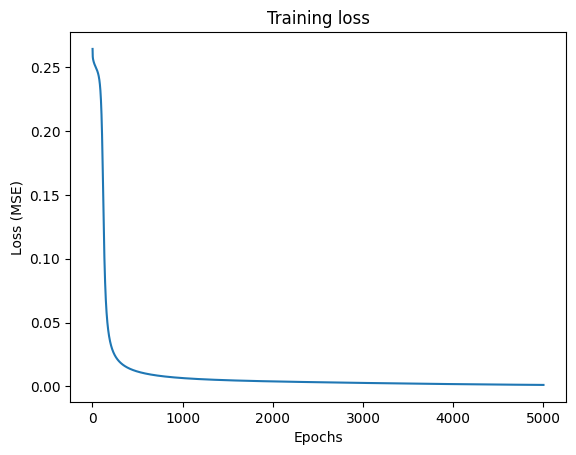

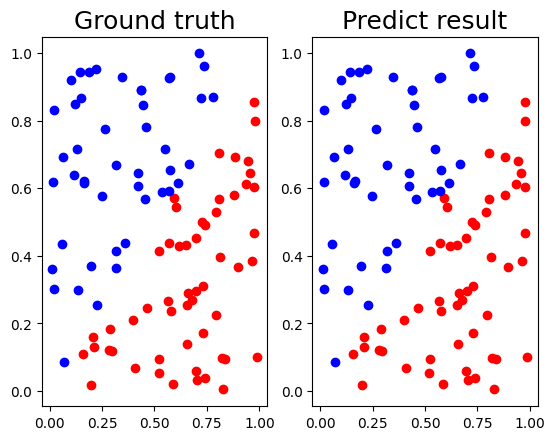

Accuracy: 100.0 %


In [48]:
np.random.seed(0)
x_train, y_train = generate_linear()

dimensions = [2, 4, 4, 1]
model = SimpleNet(dim=dimensions, lr=0.03, activation="sigmoid", optimizer="sgd")
num_epoch = 5000

total_loss = model.train(x_train, y_train, num_epoch)

show_train_loss(total_loss, num_epoch)
prediction = model.predict(x_train)

show_result(x_train, y_train, prediction)
print('Accuracy:', np.equal(y_train.reshape(1, -1), prediction).sum() / len(y_train) * 100, '%')

epoch 1 loss : 0.3108738386751848
epoch 500 loss : 0.24969102027267956
epoch 1000 loss : 0.23899815738688884
epoch 1500 loss : 0.2047857691669968
epoch 2000 loss : 0.09589504357112946
epoch 2500 loss : 0.04534898078515508
epoch 3000 loss : 0.02133590073172124
epoch 3500 loss : 0.010311731808469518
epoch 4000 loss : 0.005846214985632052
epoch 4500 loss : 0.003793089099617091
epoch 5000 loss : 0.002699370594642022


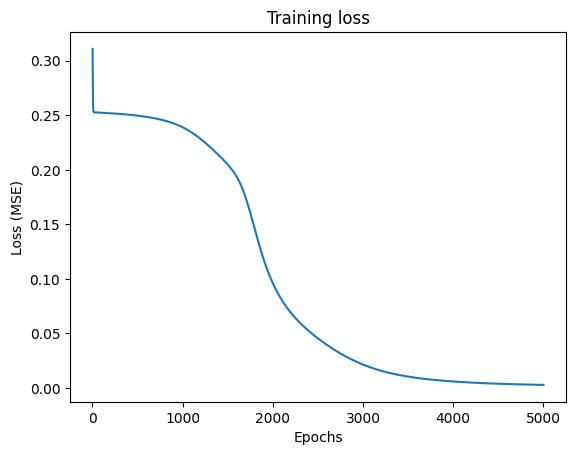

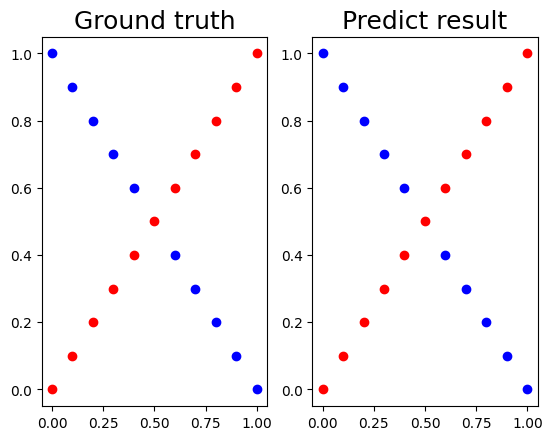

Accuracy: 100.0 %


In [29]:
np.random.seed(0)
x_train, y_train = generate_XOR_easy()

dimensions = [2, 4, 4, 1]
model = SimpleNet(dim=dimensions, lr=0.03, activation="sigmoid", optimizer="sgd")
num_epoch = 5000

total_loss = model.train(x_train, y_train, num_epoch)

show_train_loss(total_loss, num_epoch)
prediction = model.predict(x_train)

show_result(x_train, y_train, prediction)
print('Accuracy:', np.equal(y_train.reshape(1, -1), prediction).sum() / len(y_train) * 100, '%')

#### Anything you want to present

### 4. Discussion
#### Try different learning rates: [0.3, 0.03, 0.003]

[lr: 0.3] Accuracy: 100.0 %
[lr: 0.03] Accuracy: 100.0 %
[lr: 0.003] Accuracy: 100.0 %

[lr: 0.3] Accuracy: 100.0 %
[lr: 0.03] Accuracy: 100.0 %
[lr: 0.003] Accuracy: 52.38095238095239 %



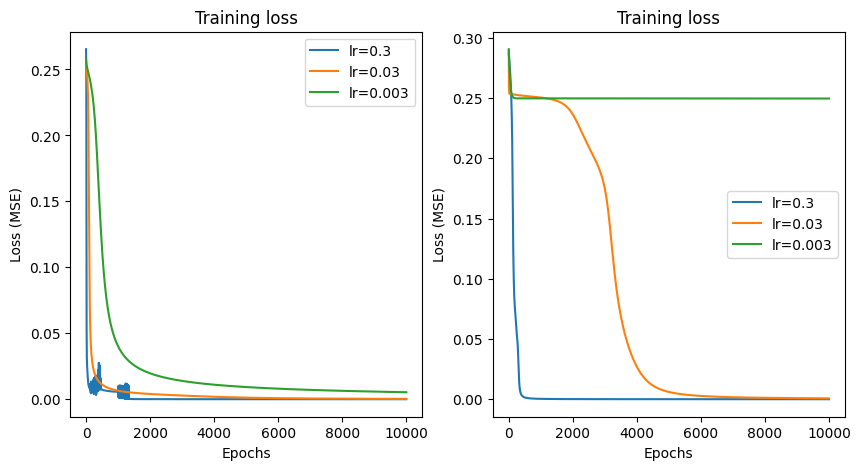

In [72]:
np.random.seed(0)
dataset = ['generate_linear', 'generate_XOR_easy']
x_trains, y_trains = [0, 0], [0, 0]
x_trains[0], y_trains[0] = generate_linear()
x_trains[1], y_trains[1] = generate_XOR_easy()

dimensions = [2, 4, 4, 1]
num_epoch = 10000

learning_rates = [0.3, 0.03, 0.003]
total_loss = []
for x_train, y_train in zip(x_trains, y_trains):
    for lr in learning_rates:
        model = SimpleNet(dim=dimensions, lr=lr, activation="sigmoid", optimizer="sgd")
        total_loss.append(model.train(x_train, y_train, num_epoch, log=False))
        prediction= model.predict(x_train)
        print('[lr: ' + str(lr) +']' + ' Accuracy:', np.equal(y_train.reshape(1, -1), prediction).sum() / len(y_train) * 100, '%')
    print()

epochs = np.arange(1, num_epoch+1, int(num_epoch / len(total_loss[0])))
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(dataset[i])
    plt.plot(epochs, total_loss[(i*3)], label='lr=0.3')
    plt.plot(epochs, total_loss[(i*3)+1], label='lr=0.03')
    plt.plot(epochs, total_loss[(i*3)+2], label='lr=0.003')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
plt.show()

#### Try different numbers of hidden units: [4, 16, 64]

[hidden: 4] Accuracy: 100.0 %
[hidden: 16] Accuracy: 100.0 %
[hidden: 64] Accuracy: 100.0 %

[hidden: 4] Accuracy: 100.0 %
[hidden: 16] Accuracy: 100.0 %
[hidden: 64] Accuracy: 100.0 %



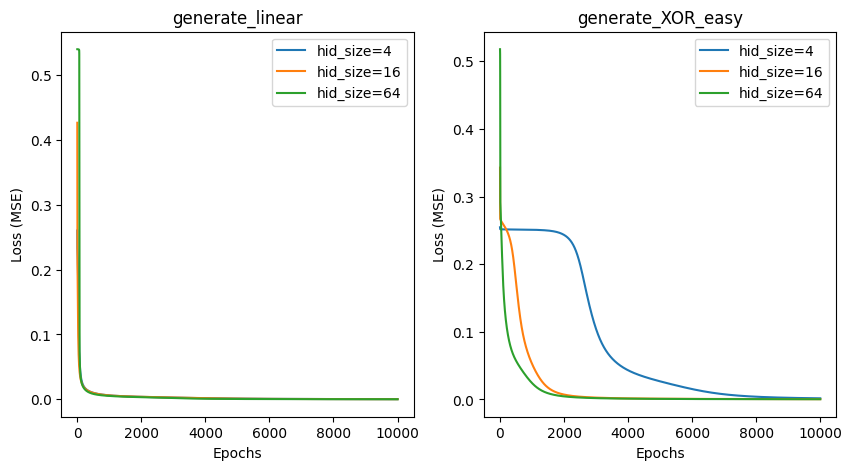

In [66]:
dims = [[2,  4,  4, 1],
        [2, 16, 16, 1],
        [2, 64, 64, 1]]

total_loss = []
for x_train, y_train in zip(x_trains, y_trains):
    for dim in dims:
        model = SimpleNet(dim=dim, lr=0.03, activation="sigmoid", optimizer="sgd")
        total_loss.append(model.train(x_train, y_train, num_epoch, log=False))
        prediction = model.predict(x_train)
        print('[hidden: ' + str(dim[1]) +']' + ' Accuracy:', np.equal(y_train.reshape(1, -1), prediction).sum() / len(y_train) * 100, '%')
    print()

epochs = np.arange(1, num_epoch+1, int(num_epoch / len(total_loss[0])))
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(dataset[i])
    plt.plot(epochs, total_loss[(i*3)], label='hid_size=4')
    plt.plot(epochs, total_loss[(i*3)+1], label='hid_size=16')
    plt.plot(epochs, total_loss[(i*3)+2], label='hid_size=64')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
plt.show()

#### Try without activation functions

[sigmoid] Accuracy: 100.0 %
[none] Accuracy: 95.0 %

[sigmoid] Accuracy: 100.0 %
[none] Accuracy: 52.38095238095239 %



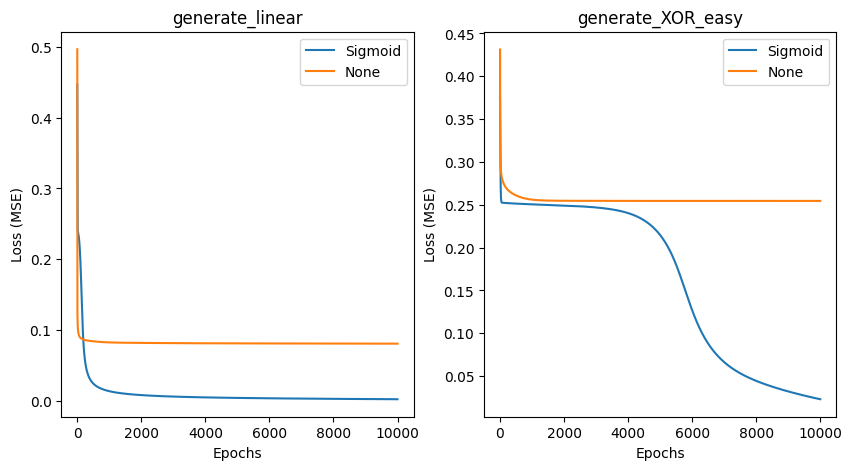

In [70]:
activations = ['sigmoid', 'none']

total_loss = []
for x_train, y_train in zip(x_trains, y_trains):
    for act in activations:
        model = SimpleNet(dim=dimensions, lr=0.01, activation=act, optimizer="sgd")
        total_loss.append(model.train(x_train, y_train, num_epoch, log=False))
        prediction = model.predict(x_train)
        print('[' + act + ']' + ' Accuracy:', np.equal(y_train.reshape(1, -1), prediction).sum() / len(y_train) * 100, '%')
    print()

epochs = np.arange(1, num_epoch+1, int(num_epoch / len(total_loss[0])))
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(dataset[i])
    plt.plot(epochs, total_loss[(i*2)], label='Sigmoid')
    plt.plot(epochs, total_loss[(i*2)+1], label='None')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
plt.show()

#### Anything you want to share

### 5. Extra
#### Implement different optimizers: [momentum, adam]

[sgd] Accuracy: 100.0 %
[momentum] Accuracy: 100.0 %
[adam] Accuracy: 100.0 %

[sgd] Accuracy: 100.0 %
[momentum] Accuracy: 100.0 %
[adam] Accuracy: 100.0 %



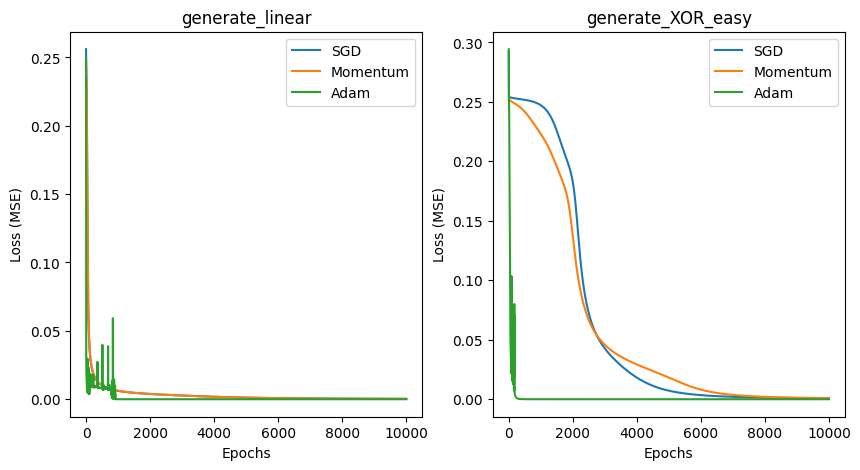

In [68]:
optimizers = ['sgd', 'momentum', 'adam']

total_loss = []
for x_train, y_train in zip(x_trains, y_trains):
    for opt in optimizers:
        model = SimpleNet(dim=dimensions, lr=0.03, activation="sigmoid", optimizer=opt)
        total_loss.append(model.train(x_train, y_train, num_epoch, log=False))
        prediction = model.predict(x_train)
        print('[' + opt +']' + ' Accuracy:', np.equal(y_train.reshape(1, -1), prediction).sum() / len(y_train) * 100, '%')
    print()

epochs = np.arange(1, num_epoch+1, int(num_epoch / len(total_loss[0])))
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(dataset[i])
    plt.plot(epochs, total_loss[(i*3)], label='SGD')
    plt.plot(epochs, total_loss[(i*3)+1], label='Momentum')
    plt.plot(epochs, total_loss[(i*3)+2], label='Adam')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
plt.show()

#### Implement different activation functions: [tanh, relu]

[sigmoid] Accuracy: 100.0 %
[tanh] Accuracy: 100.0 %
[relu] Accuracy: 100.0 %

[sigmoid] Accuracy: 100.0 %
[tanh] Accuracy: 100.0 %
[relu] Accuracy: 100.0 %



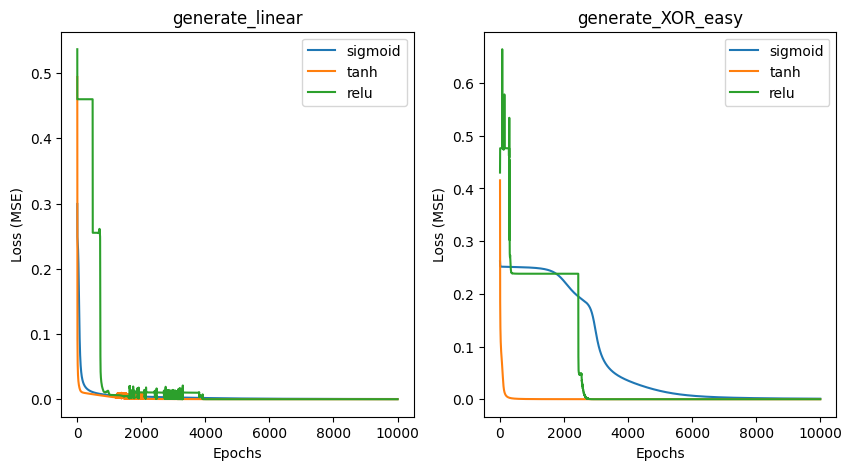

In [69]:
activations = ['sigmoid', 'tanh', 'relu']

total_loss = []
for x_train, y_train in zip(x_trains, y_trains):
    for act in activations:
        model = SimpleNet(dim=dimensions, lr=0.03, activation=act, optimizer='sgd')
        total_loss.append(model.train(x_train, y_train, num_epoch, log=False))
        prediction = model.predict(x_train)
        print('[' + act +']' + ' Accuracy:', np.equal(y_train.reshape(1, -1), prediction).sum() / len(y_train) * 100, '%')
    print()

epochs = np.arange(1, num_epoch+1, int(num_epoch / len(total_loss[0])))
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(dataset[i])
    plt.plot(epochs, total_loss[(i*3)], label='sigmoid')
    plt.plot(epochs, total_loss[(i*3)+1], label='tanh')
    plt.plot(epochs, total_loss[(i*3)+2], label='relu')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
plt.show()

epoch 1 loss : 1.5796120909132516
epoch 500 loss : 0.05964718091975972
epoch 1000 loss : 0.053139244705902255
epoch 1500 loss : 0.05186360668214159
epoch 2000 loss : 0.05177614404215188
epoch 2500 loss : 0.051381629664232
epoch 3000 loss : 0.05182088182278784
epoch 3500 loss : 0.05218048945653521
epoch 4000 loss : 0.05232235868045758
epoch 4500 loss : 0.052854423120495805
epoch 5000 loss : 0.0528137605144475
epoch 5500 loss : 0.05011238429944559
epoch 6000 loss : 0.002691703685704376
epoch 6500 loss : 5.823274425706978e-05
epoch 7000 loss : 0.0007867631094730628
epoch 7500 loss : 0.002480192028717635
epoch 8000 loss : 0.002765048727687622
epoch 8500 loss : 0.00295473896325914
epoch 9000 loss : 0.00299452577175528
epoch 9500 loss : 0.0014378759375752383
epoch 10000 loss : 0.000805127438296008


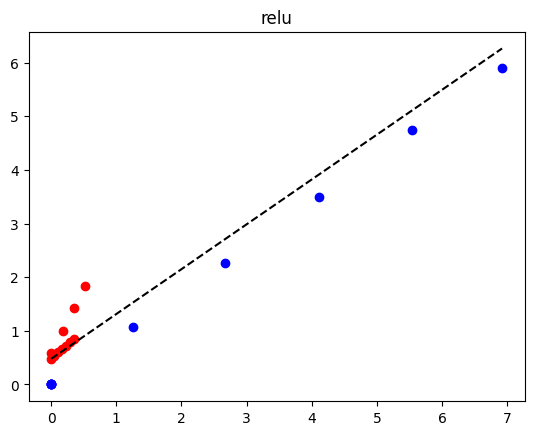

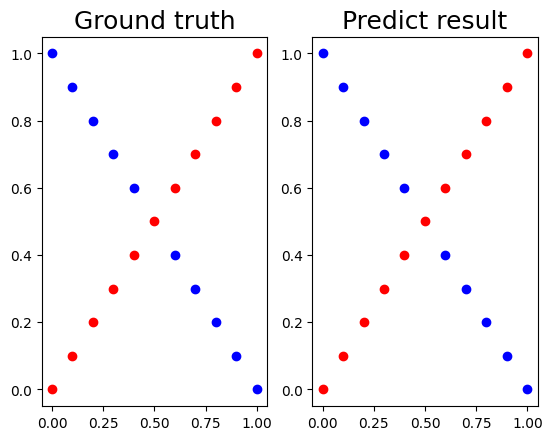

In [197]:
np.random.seed(0)
# x_train, y_train = generate_linear()
x_train, y_train = generate_XOR_easy()

dimensions = [2, 4, 2, 1]
model = SimpleNet(dim=dimensions, lr=0.01, activation="relu", optimizer="sgd")
num_epoch = 10000

total_loss = model.train(x_train, y_train, num_epoch)

new_x = []
for x in x_train:
    x = x.reshape(-1, 1)
    for i in range(2):
        w, b = model.layers[i].layer
        z = np.dot(w, x) + b
        a = model.layers[i].activation(z)
        x = a
    new_x.append(a)

# plt.figure(figsize=(10, 5))
plt.title('relu')
for i in range(x_train.shape[0]):
    if y_train[i] == 0:
        plt.plot(new_x[i][0], new_x[i][1], 'ro')
    else:
        plt.plot(new_x[i][0], new_x[i][1], 'bo')

w, b = model.layers[2].layer
slope = -w[0][0] / w[0][1]
intercept = -b[0] / w[0][1]
# print(slope, intercept)

n = np.array(new_x)
x_range = np.linspace(n[:, 0].min(), n[:, 0].max(), 100)
y_range = slope * x_range + intercept

plt.plot(x_range, y_range, '--', c='black')
plt.show()

prediction = model.predict(x_train)
show_result(x_train, y_train, prediction)